## Update: This is a continuation of my first ML with sports data exploration.  The first one did not work out, as expected.  This one, however, uses some gentle webscraping to grab some information and process it.  I conclude by running best_models from pycaret, then my own version of those models to see how well they compare.

## This version of the code is much improved and the results are nearly aligned with my expectations.

New things!

to call a specific version of python from terminal, use this: py -3.8 or py -version number

Then, to install a package/module for a specific version, specify pip: pip3.8 install pycaret

ALSO: see note below regarding protocol buffers

In [1]:
## NOTE: for pycaret to work, I had to downgrade protocol buffers to 3.20.0: pip3.8 install protobuf==3.20.0.

## this package was at 4.25.1, so I'll need to swap that back when I'm done.

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datatile.summary.df import DataFrameSummary
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import interpret  # < python 3.12
from interpret.glassbox import ExplainableBoostingClassifier  # < python 3.12
from interpret import show  # < python 3.12
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import pygwalker as pyg

import pycaret  # < python 3.12
from pycaret.classification import *  # < python 3.12

# some scraping modules and related
# import packages
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from datetime import datetime, timedelta
import time
from bs4 import BeautifulSoup

from random import randint
import os
import csv

# warning: you must read the site's terms for automated pulls (i.e. webscraping) and whether or not it's allowed.  the sites below have fantastic examples of help pages for this sort of thing so pay attention and adhere.  remember, if the dude abides, you should too.

In [3]:
# team stats:

team_stats_url = 'https://www.sports-reference.com/cbb/seasons/men/2024-advanced-school-stats.html'

# KenPom rankings:

kenpom_rankings_url = 'https://kenpom.com/'

In [4]:
# set options and open instance

options = Options()
options.headless = False  # T/F toggles visibility when running.  Used for troubleshooting and building sequentially
# driver = webdriver.Chrome(options = options)
driver_path = 'C:\\Users\\mkroh\\Desktop\\chrome driver\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe'
driver = webdriver.Chrome(executable_path=driver_path)  # note this may change.

In [5]:
# instance for team stats

driver.get(team_stats_url)

In [6]:
data_table_raw = driver.find_element(By.ID, "adv_school_stats")

In [7]:
data_table_df = pd.read_html(data_table_raw.get_attribute('outerHTML'))[0]

In [8]:
data_table_df.head(5)

Unnamed: 0_level_0 Unnamed: 1_level_0 Overall                               \
                  Rk             School       G   W   L  W-L%     SRS    SOS   
0                  1  Abilene Christian      18   7  11  .389   -4.63  -0.74   
1                  2          Air Force      17   7  10  .412   -4.34  -3.05   
2                  3              Akron      18  14   4  .778    6.20  -0.05   
3                  4            Alabama      18  12   6  .667   23.58   9.30   
4                  5        Alabama A&M      18   3  15  .167  -17.58  -3.36   

  Unnamed: 8_level_0 Conf.  ... School Advanced                                \
  Unnamed: 8_level_1     W  ...            3PAr   TS%  TRB%  AST%  STL%  BLK%   
0                NaN     2  ...            .271  .526  46.5  51.2  10.6   4.3   
1                NaN     0  ...            .440  .559  48.5  64.2  11.1  13.3   
2                NaN     6  ...            .431  .578  53.5  52.5   9.5   8.1   
3                NaN     4  ...            .475  .618  54.5  52.1  10.2  11.3   
4                NaN     2  ...            .271  .506  47.9  43.2  10.3  11.1   

                            
   eFG%  TOV%  ORB% FT/FGA  
0  .479  15.6  25.6   .296  
1  .536  17.7  24.7   .228  
2  .550  14.7  32.4   .233  
3  .581  14.8  34.9   .301  
4  .453  19.6  31.7   .323  

[5 rows x 34 columns]

In [9]:
# close url and driver instance

driver.quit()

In [10]:
# need to drop the extra row in the header:
# since I have a split header, i need to do something special here instead of dropping an indexed row.
data_table_df.columns = data_table_df.columns.droplevel(0)

# Reset the index if needed
data_table_df = data_table_df.reset_index(drop=True)

In [11]:
data_table_df.head(5)

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8_level_1,W,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
0,1,Abilene Christian,18,7,11,.389,-4.63,-0.74,NaN,2,...,.271,.526,46.5,51.2,10.6,4.3,.479,15.6,25.6,.296
1,2,Air Force,17,7,10,.412,-4.34,-3.05,NaN,0,...,.440,.559,48.5,64.2,11.1,13.3,.536,17.7,24.7,.228
2,3,Akron,18,14,4,.778,6.20,-0.05,NaN,6,...,.431,.578,53.5,52.5,9.5,8.1,.550,14.7,32.4,.233
3,4,Alabama,18,12,6,.667,23.58,9.30,NaN,4,...,.475,.618,54.5,52.1,10.2,11.3,.581,14.8,34.9,.301
4,5,Alabama A&M,18,3,15,.167,-17.58,-3.36,NaN,2,...,.271,.506,47.9,43.2,10.3,11.1,.453,19.6,31.7,.323


Excellent.  Now I have the data_table and I can grab the KenPom data.

In [12]:
# set options and open instance

options = Options()
options.headless = False  # T/F toggles visibility when running.  Used for troubleshooting and building sequentially
# driver = webdriver.Chrome(options = options)
driver_path = 'C:\\Users\\mkroh\\Desktop\\chrome driver\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe'
driver = webdriver.Chrome(executable_path=driver_path)  # note this may change.

In [13]:
# instance for team stats

driver.get(kenpom_rankings_url)

In [14]:
kenpom_rankings_raw = driver.find_element(By.ID, "ratings-table")

In [15]:
kenpom_rankings_df = pd.read_html(kenpom_rankings_raw.get_attribute('outerHTML'))[0]

In [16]:
kenpom_rankings_df.head(5)

Unnamed: 0_level_0  Unnamed: 1_level_0  Unnamed: 2_level_0  \
                   Rk                Team                Conf   
   Unnamed: 0_level_2  Unnamed: 1_level_2  Unnamed: 2_level_2   
                   Rk                Team                Conf   
   Unnamed: 0_level_4  Unnamed: 1_level_4  Unnamed: 2_level_4   
                   Rk                Team                Conf   
   Unnamed: 0_level_6  Unnamed: 1_level_6  Unnamed: 2_level_6   
                   Rk                Team                Conf   
   Unnamed: 0_level_8  Unnamed: 1_level_8  Unnamed: 2_level_8   
                   Rk                Team                Conf   
  Unnamed: 0_level_10 Unnamed: 1_level_10 Unnamed: 2_level_10   
                   Rk                Team                Conf   
  Unnamed: 0_level_12 Unnamed: 1_level_12 Unnamed: 2_level_12   
                   Rk                Team                Conf   
  Unnamed: 0_level_14 Unnamed: 1_level_14 Unnamed: 2_level_14   
                   Rk                Team                Conf   
  Unnamed: 0_level_16 Unnamed: 1_level_16 Unnamed: 2_level_16   
                   Rk                Team                Conf   
  Unnamed: 0_level_18 Unnamed: 1_level_18 Unnamed: 2_level_18   
                   Rk                Team                Conf   
0                   1             Houston                 B12   
1                   2              Purdue                 B10   
2                   3             Arizona                 P12   
3                   4           Tennessee                 SEC   
4                   5              Auburn                 SEC   

   Unnamed: 3_level_0  Unnamed: 4_level_0  Unnamed: 5_level_0  \
                  W-L               AdjEM                AdjO   
   Unnamed: 3_level_2  Unnamed: 4_level_2  Unnamed: 5_level_2   
                  W-L               AdjEM                AdjO   
   Unnamed: 3_level_4  Unnamed: 4_level_4  Unnamed: 5_level_4   
                  W-L               AdjEM                AdjO   
   Unnamed: 3_level_6  Unnamed: 4_level_6  Unnamed: 5_level_6   
                  W-L               AdjEM                AdjO   
   Unnamed: 3_level_8  Unnamed: 4_level_8  Unnamed: 5_level_8   
                  W-L               AdjEM                AdjO   
  Unnamed: 3_level_10 Unnamed: 4_level_10 Unnamed: 5_level_10   
                  W-L               AdjEM                AdjO   
  Unnamed: 3_level_12 Unnamed: 4_level_12 Unnamed: 5_level_12   
                  W-L               AdjEM                AdjO   
  Unnamed: 3_level_14 Unnamed: 4_level_14 Unnamed: 5_level_14   
                  W-L               AdjEM                AdjO   
  Unnamed: 3_level_16 Unnamed: 4_level_16 Unnamed: 5_level_16   
                  W-L               AdjEM                AdjO   
  Unnamed: 3_level_18 Unnamed: 4_level_18 Unnamed: 5_level_18   
                  W-L               AdjEM                AdjO   
0                16-2               33.53               119.1   
1                17-2               30.25               125.9   
2                14-4               27.84               121.6   
3                14-4               27.44               118.9   
4                16-2               26.92               121.3   

   Unnamed: 6_level_0  Unnamed: 7_level_0  Unnamed: 8_level_0  \
                 AdjO                AdjD                AdjD   
   Unnamed: 6_level_2  Unnamed: 7_level_2  Unnamed: 8_level_2   
                 AdjO                AdjD                AdjD   
   Unnamed: 6_level_4  Unnamed: 7_level_4  Unnamed: 8_level_4   
                 AdjO                AdjD                AdjD   
   Unnamed: 6_level_6  Unnamed: 7_level_6  Unnamed: 8_level_6   
                 AdjO                AdjD                AdjD   
   Unnamed: 6_level_8  Unnamed: 7_level_8  Unnamed: 8_level_8   
                 AdjO                AdjD                AdjD   
  Unnamed: 6_level_10 Unnamed: 7_level_10 Unnamed: 8_level_10   
                 AdjO               

In [17]:
# close url and driver instance

driver.quit()

In [18]:
# Hmm, need a count here:
num_header_rows = kenpom_rankings_df.columns.nlevels
print(num_header_rows)

20


In [19]:
kenpom_rankings_df.columns = kenpom_rankings_df.columns.droplevel([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

# Reset the index if needed
kenpom_rankings_df = kenpom_rankings_df.reset_index(drop=True)

In [20]:
kenpom_rankings_df.head(5)

,Rk,Team,Conf,W-L,AdjEM,AdjO,AdjO,AdjD,AdjD,AdjT,...,Luck,Luck,AdjEM,AdjEM.1,OppO,OppO.1,OppD,OppD.1,AdjEM,AdjEM.1
0,1,Houston,B12,16-2,33.53,119.1,18,85.6,1,63.4,...,-0.036,260,3.12,84,108.9,83,105.8,98,-1.22,216
1,2,Purdue,B10,17-2,30.25,125.9,2,95.6,13,67.9,...,0.056,84,12.43,1,114.2,1,101.8,2,10.15,11
2,3,Arizona,P12,14-4,27.84,121.6,7,93.7,5,73.5,...,-0.029,244,10.05,3,113.5,2,103.5,25,9.22,15
3,4,Tennessee,SEC,14-4,27.44,118.9,19,91.5,2,69.9,...,-0.057,287,10.56,2,113.4,3,102.9,13,7.76,20
4,5,Auburn,SEC,16-2,26.92,121.3,9,94.4,6,70.2,...,-0.066,305,2.74,95,108.0,123,105.3,76,0.45,158


ok, have both dataframes to work with now.

Time to filter for Big12 teams

In [21]:
# Big12 teams here.  need to verify names on lists. 

# stats/kenpom official listing:
# Baylor
# Brigham Young / BYU
# Cincinnati
# Houston
# Iowa State / Iowa St.
# Kansas
# Kansas State / Kansas St.
# Oklahoma
# Oklahoma State / Oklahoma St.
# Texas Tech
# TCU
# Texas
# Central Florida / UCF
# West Virginia

# big_12_teams = ['Baylor', 'Brigham Young', 'BYU', 'Cincinnati', 'Houston', 'Iowa State', 'Iowa St.', 
#                 'Kansas', 'Kansas State', 'Kansas St.', 'Oklahoma', 'Oklahoma State', 'Oklahoma St.', 
#                 'Texas Tech', 'TCU', 'Texas', 'Central Florida', 'UCF', 'West Virginia']

At this point, I need to combine the information from both tables and match each team to it's corresponding team row in the other database.  This will bring stats and kenpom rankings together.

From there, I will need to build the schedule for each team.

From there, I will need to build my training dataframe, or the dataframe that shows the matchups and results up to this point.  The caveat is that kenpom and stats are updated regularly, so I will intentionally use the stats and rankings that each team has earned up to this point to train.

From there, I will use the remaining schedule for Big12 schools to predict matchups and see how I do.

In order to tackle this problem in smaller chunks, I will start with big12 schools and their opponents only.  This will bring in an array of other teams, good and bad, to the dataset to hopefully keep it robust.

In [22]:
# to get some level of uniformity, I rename all of the columns to something different.  for stats, add _stats to the column
# names.  for kenpom, add _kenpom to the column names.  Finally, change stats 'school' to 'team'

# first, some copies:

data_table_df_copy = data_table_df.copy()
kenpom_rankings_df_copy = kenpom_rankings_df.copy()

In [23]:
# add suffixes to kenpom:
kenpom_rankings_df_copy = kenpom_rankings_df_copy.rename(columns=lambda x: x + '_kenpom' if x != 'Team' else x)

print(kenpom_rankings_df_copy.head(5))

   Rk_kenpom       Team Conf_kenpom W-L_kenpom  AdjEM_kenpom  AdjO_kenpom  \
0          1    Houston         B12       16-2         33.53        119.1   
1          2     Purdue         B10       17-2         30.25        125.9   
2          3    Arizona         P12       14-4         27.84        121.6   
3          4  Tennessee         SEC       14-4         27.44        118.9   
4          5     Auburn         SEC       16-2         26.92        121.3   

   AdjO_kenpom  AdjD_kenpom  AdjD_kenpom  AdjT_kenpom  ...  Luck_kenpom  \
0           18         85.6            1         63.4  ...       -0.036   
1            2         95.6           13         67.9  ...        0.056   
2            7         93.7            5         73.5  ...       -0.029   
3           19         91.5            2         69.9  ...       -0.057   
4            9         94.4            6         70.2  ...       -0.066   

   Luck_kenpom  AdjEM_kenpom  AdjEM.1_kenpom  OppO_kenpom  OppO.1_kenpom  \
0         

In [24]:
# School to Team:
data_table_df_copy = data_table_df_copy.rename(columns = {'School': 'Team'})


# stats change, add a suffix:
data_table_df_copy = data_table_df_copy.rename(columns=lambda x: x + '_stats' if x != 'Team' else x)

print(data_table_df_copy.head(5))

  Rk_stats               Team G_stats W_stats L_stats W-L%_stats SRS_stats  \
0        1  Abilene Christian      18       7      11       .389     -4.63   
1        2          Air Force      17       7      10       .412     -4.34   
2        3              Akron      18      14       4       .778      6.20   
3        4            Alabama      18      12       6       .667     23.58   
4        5        Alabama A&M      18       3      15       .167    -17.58   

  SOS_stats  Unnamed: 8_level_1_stats W_stats  ... 3PAr_stats  TS%_stats  \
0     -0.74                       NaN       2  ...       .271       .526   
1     -3.05                       NaN       0  ...       .440       .559   
2     -0.05                       NaN       6  ...       .431       .578   
3      9.30                       NaN       4  ...       .475       .618   
4     -3.36                       NaN       2  ...       .271       .506   

  TRB%_stats AST%_stats  STL%_stats BLK%_stats eFG%_stats  TOV%_stats  \
0

In [25]:
# now, because the names in the two dataframes don't match exactly, I need to use fuzzy logic to match teams:

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [26]:
# write a function to find the best match:

# def find_best_match(team, choices):
#     if not isinstance(team, str) or not all(isinstance(choice, str) for choice in choices):
#         return None, 0  # Return a default value if not a valid string
    
#     result = process.extractOne(team, choices, scorer=fuzz.token_sort_ratio)
#     return result[0], result[1]  # Return a tuple with the match and score

def find_best_match(team, choices):
    known_abbreviations = {'Brigham Young': 'BYU', 'Central Florida': 'UCF', 'Southern Methodist': 'SMU', 
                       'California Baptist': 'Cal Baptist', 'College of Charleston': 'Charleston', 
                      'Florida International': 'FIU', 'Kansas City': 'UMKC', 'Long Island University': 'LIU', 
                      'Loyola (IL)': 'Loyola Chicago', 'Maryland-Baltimore County': 'UMBC', 'Massachusetts-Lowell': 
                      'UMass Lowell', 'Nevada-Las Vegas': 'UNLV', 'Omaha': 'Nebraska Omaha', 'Pennsylvania': 'Penn', 
                      'Southern California': 'USC', 'Virginia Commonwealth': 'VCU', 'Louisiana State': 'LSU', 
                          'Southern Mississippi': 'Southern Miss', 'South Carolina Upstate': 'USC Upstate', 
                          'Miami': 'Miami FL'}
    
    if team in known_abbreviations:
        return known_abbreviations[team], 100
    
    if not isinstance(team, str) or not all(isinstance(choice, str) for choice in choices):
        return None, 0  # Return a default value if not a valid string
    
    result = process.extractOne(team, choices, scorer=fuzz.token_sort_ratio)
    return result[0], result[1]  # Return a tuple with the match and score

# and a dictionary for the matches
matches = {}

In [27]:
# Iterate over teams in data_table_df_copy and find the best match in kenpom_rankings_df_copy

for team in data_table_df_copy['Team']:
    match, score = find_best_match(team, kenpom_rankings_df_copy['Team'])
    if score >= 80:
        matches[team] = (match, score)

In [28]:
print(len(matches), " Out of 362")

362  Out of 362


Woot!  Got em all.  There are 362 teams to match and the known_abbreviations dictionary worked well to capture the ones that didn't fuzzy match.

In [29]:
# Create a new column in data_table_df_copy with the matched team names
data_table_df_copy['matched_team'] = data_table_df_copy['Team'].map(lambda x: matches[x][0] if x in matches else None)

In [30]:
# quick .csv file analysis shows 13 teams that didn't get matched.  This aligns with the length of the matches dictionary.
# I don't want to delete these rows when I start feature engineering, so it's straight-forward enogh to manually include 
# these in the 'known_abbreviations' section above.

# known_abbreviations = {'Brigham Young': 'BYU', 'Central Florida': 'UCF', 'Southern Methodist': 'SMU', 
#                        'California Baptist': 'Cal Baptist', 'College of Charleston': 'Charleston', 
#                       'Florida International': 'FIU', 'Kansas City': 'UMKC', 'Long Island University': 'LIU', 
#                       'Loyola (IL)': 'Loyola Chicago', 'Maryland-Baltimore County': 'UMBC', 'Massachusetts-Lowell': 
#                       'UMass Lowell', 'Nevada-Las Vegas': 'UNLV', 'Omaha': 'Nebraska Omaha', 'Pennsylvania': 'Penn', 
#                       'Southern California': 'USC', 'Virginia Commonwealth': 'VCU', 'Miami': 'Miami FL'}

# Brigham Young / BYU
# California Baptist / Cal Baptist
# Central Florida / UCF
# College of Charleston / Charleston
# Florida International / FIU
# Kansas City / UMKC
# Long Island University / LIU

# Louisiana State / LSU
# Southern Mississippi / Southern Miss

# Loyola (IL) / Loyola Chicago
# Maryland-Baltimore County / UMBC
# Massachusetts-Lowell / UMass Lowell
# Nevada-Las Vegas / UNLV
# Omaha / Nebraska Omaha
# Pennsylvania / Penn
# Southern California / USC
# Southern Methodist / SMU
# Virginia Commonwealth / VCU

# Miami / Miami FL


In [31]:
data_table_df_copy.head(5)

,Rk_stats,Team,G_stats,W_stats,L_stats,W-L%_stats,SRS_stats,SOS_stats,Unnamed: 8_level_1_stats,W_stats,...,TS%_stats,TRB%_stats,AST%_stats,STL%_stats,BLK%_stats,eFG%_stats,TOV%_stats,ORB%_stats,FT/FGA_stats,matched_team
0,1,Abilene Christian,18,7,11,.389,-4.63,-0.74,NaN,2,...,.526,46.5,51.2,10.6,4.3,.479,15.6,25.6,.296,Abilene Christian
1,2,Air Force,17,7,10,.412,-4.34,-3.05,NaN,0,...,.559,48.5,64.2,11.1,13.3,.536,17.7,24.7,.228,Air Force
2,3,Akron,18,14,4,.778,6.20,-0.05,NaN,6,...,.578,53.5,52.5,9.5,8.1,.550,14.7,32.4,.233,Akron
3,4,Alabama,18,12,6,.667,23.58,9.30,NaN,4,...,.618,54.5,52.1,10.2,11.3,.581,14.8,34.9,.301,Alabama
4,5,Alabama A&M,18,3,15,.167,-17.58,-3.36,NaN,2,...,.506,47.9,43.2,10.3,11.1,.453,19.6,31.7,.323,Alabama A&M


In [32]:
# create a .csv to analyze matched_team success.

data_table_df_copy.to_csv('data_table_copy.csv', index=False)

In [33]:
# Merge dataframes based on the new 'matched_team' column
merged_data_df = pd.merge(data_table_df_copy, kenpom_rankings_df_copy, left_on='matched_team', right_on='Team', how='outer', suffixes=('_data_table', '_kenpom_rankings'))

In [34]:
merged_data_df.to_csv('merged_data_df.csv', index=False)

In [35]:
merged_data_df.head(5)

,Rk_stats,Team_data_table,G_stats,W_stats,L_stats,W-L%_stats,SRS_stats,SOS_stats,Unnamed: 8_level_1_stats,W_stats,...,Luck_kenpom,Luck_kenpom,AdjEM_kenpom,AdjEM.1_kenpom,OppO_kenpom,OppO.1_kenpom,OppD_kenpom,OppD.1_kenpom,AdjEM_kenpom,AdjEM.1_kenpom
0,1,Abilene Christian,18,7,11,.389,-4.63,-0.74,NaN,2,...,0.001,181.0,0.36,156.0,105.8,264.0,105.5,84.0,0.02,171.0
1,2,Air Force,17,7,10,.412,-4.34,-3.05,NaN,0,...,-0.039,265.0,-4.12,309.0,105.9,258.0,110.0,344.0,-10.33,359.0
2,3,Akron,18,14,4,.778,6.20,-0.05,NaN,6,...,0.032,124.0,0.09,170.0,108.0,127.0,107.9,222.0,4.73,56.0
3,4,Alabama,18,12,6,.667,23.58,9.30,NaN,4,...,-0.074,313.0,9.66,6.0,113.0,4.0,103.4,23.0,8.52,17.0
4,5,Alabama A&M,18,3,15,.167,-17.58,-3.36,NaN,2,...,0.074,55.0,-1.93,244.0,107.0,182.0,108.9,295.0,3.64,75.0


In [36]:
column_names = merged_data_df.columns
print(column_names)

Index(['Rk_stats', 'Team_data_table', 'G_stats', 'W_stats', 'L_stats',
       'W-L%_stats', 'SRS_stats', 'SOS_stats', 'Unnamed: 8_level_1_stats',
       'W_stats', 'L_stats', 'Unnamed: 11_level_1_stats', 'W_stats', 'L_stats',
       'Unnamed: 14_level_1_stats', 'W_stats', 'L_stats',
       'Unnamed: 17_level_1_stats', 'Tm._stats', 'Opp._stats',
       'Unnamed: 20_level_1_stats', 'Pace_stats', 'ORtg_stats', 'FTr_stats',
       '3PAr_stats', 'TS%_stats', 'TRB%_stats', 'AST%_stats', 'STL%_stats',
       'BLK%_stats', 'eFG%_stats', 'TOV%_stats', 'ORB%_stats', 'FT/FGA_stats',
       'matched_team', 'Rk_kenpom', 'Team_kenpom_rankings', 'Conf_kenpom',
       'W-L_kenpom', 'AdjEM_kenpom', 'AdjO_kenpom', 'AdjO_kenpom',
       'AdjD_kenpom', 'AdjD_kenpom', 'AdjT_kenpom', 'AdjT_kenpom',
       'Luck_kenpom', 'Luck_kenpom', 'AdjEM_kenpom', 'AdjEM.1_kenpom',
       'OppO_kenpom', 'OppO.1_kenpom', 'OppD_kenpom', 'OppD.1_kenpom',
       'AdjEM_kenpom', 'AdjEM.1_kenpom'],
      dtype='object')


reviewing the merged_data_df .csv file, there are several columns and rows we can eliminate off the bat.

Columns:
'Rk_stats'
'Unnamed: 8_level_1_stats'
'Unnamed: 11_level_1_stats'
'Unnamed: 14_level_1_stats'
'Unnamed: 17_level_1_stats'
'Unnamed: 20_level_1_stats'
'Team_kenpom_rankings'
'Team_data_table'
'Conf_kenpom'

Also need to move 'matched_team' to first column and rename 'Team'

Rows:
22:57


In [37]:
merged_data_df.shape

(398, 56)

In [38]:
drop_cols = ['Rk_stats', 'Unnamed: 8_level_1_stats', 'Unnamed: 11_level_1_stats', 'Unnamed: 14_level_1_stats', 
             'Unnamed: 17_level_1_stats', 'Unnamed: 20_level_1_stats', 'Team_kenpom_rankings', 'Team_data_table', 
             'Conf_kenpom']

merged_data_df = merged_data_df.drop(drop_cols, axis = 1)  # axis = 1 for columns.

merged_data_df.shape

(398, 47)

In [39]:
merged_data_df.head(60)

,G_stats,W_stats,L_stats,W-L%_stats,SRS_stats,SOS_stats,W_stats,L_stats,W_stats,L_stats,...,Luck_kenpom,Luck_kenpom,AdjEM_kenpom,AdjEM.1_kenpom,OppO_kenpom,OppO.1_kenpom,OppD_kenpom,OppD.1_kenpom,AdjEM_kenpom,AdjEM.1_kenpom
0,18,7,11,.389,-4.63,-0.74,2,5,4,3,...,0.001,181.0,0.36,156.0,105.8,264.0,105.5,84.0,0.02,171.0
1,17,7,10,.412,-4.34,-3.05,0,5,4,6,...,-0.039,265.0,-4.12,309.0,105.9,258.0,110.0,344.0,-10.33,359.0
2,18,14,4,.778,6.20,-0.05,6,0,8,0,...,0.032,124.0,0.09,170.0,108.0,127.0,107.9,222.0,4.73,56.0
3,18,12,6,.667,23.58,9.30,4,1,8,1,...,-0.074,313.0,9.66,6.0,113.0,4.0,103.4,23.0,8.52,17.0
4,18,3,15,.167,-17.58,-3.36,2,3,1,4,...,0.074,55.0,-1.93,244.0,107.0,182.0,108.9,295.0,3.64,75.0
5,18,9,9,.500,-8.19,-1.05,4,1,4,2,...,0.069,65.0,1.14,132.0,108.4,106.0,107.3,184.0,11.24,8.0
6,19,10,9,.526,-6.00,-5.61,2,2,6,2,...,0.008,170.0,-5.25,329.0,102.9,342.0,108.1,240.0,-4.20,291.0
7,17,2,15,.118,-14.53,3.03,1,3,1,1,...,-0.031,248.0,8.06,18.0,110.8,31.0,102.8,10.0,13.28,4.0
8,19,10,9,.526,-7.57,-7.29,4,2,6,1,...,0.012,165.0,-7.66,355.0,102.2,354.0,109.9,336.0,-5.40,314.0
9,19,15,4,.789,6.70,-2.36,6,1,8,0,...,0.008,168.0,-1.75,234.0,106.8,199.0,108.5,258.0,-0.26,178.0


In [40]:
drop_rows = list(range(20,56))

merged_data_df = merged_data_df.drop(index=drop_rows)

merged_data_df.shape

(362, 47)

In [41]:
merged_data_df.head(30)

,G_stats,W_stats,L_stats,W-L%_stats,SRS_stats,SOS_stats,W_stats,L_stats,W_stats,L_stats,...,Luck_kenpom,Luck_kenpom,AdjEM_kenpom,AdjEM.1_kenpom,OppO_kenpom,OppO.1_kenpom,OppD_kenpom,OppD.1_kenpom,AdjEM_kenpom,AdjEM.1_kenpom
0,18,7,11,.389,-4.63,-0.74,2,5,4,3,...,0.001,181.0,0.36,156.0,105.8,264.0,105.5,84.0,0.02,171.0
1,17,7,10,.412,-4.34,-3.05,0,5,4,6,...,-0.039,265.0,-4.12,309.0,105.9,258.0,110.0,344.0,-10.33,359.0
2,18,14,4,.778,6.20,-0.05,6,0,8,0,...,0.032,124.0,0.09,170.0,108.0,127.0,107.9,222.0,4.73,56.0
3,18,12,6,.667,23.58,9.30,4,1,8,1,...,-0.074,313.0,9.66,6.0,113.0,4.0,103.4,23.0,8.52,17.0
4,18,3,15,.167,-17.58,-3.36,2,3,1,4,...,0.074,55.0,-1.93,244.0,107.0,182.0,108.9,295.0,3.64,75.0
5,18,9,9,.500,-8.19,-1.05,4,1,4,2,...,0.069,65.0,1.14,132.0,108.4,106.0,107.3,184.0,11.24,8.0
6,19,10,9,.526,-6.00,-5.61,2,2,6,2,...,0.008,170.0,-5.25,329.0,102.9,342.0,108.1,240.0,-4.20,291.0
7,17,2,15,.118,-14.53,3.03,1,3,1,1,...,-0.031,248.0,8.06,18.0,110.8,31.0,102.8,10.0,13.28,4.0
8,19,10,9,.526,-7.57,-7.29,4,2,6,1,...,0.012,165.0,-7.66,355.0,102.2,354.0,109.9,336.0,-5.40,314.0
9,19,15,4,.789,6.70,-2.36,6,1,8,0,...,0.008,168.0,-1.75,234.0,106.8,199.0,108.5,258.0,-0.26,178.0


In [42]:
merged_data_df = merged_data_df.reset_index(drop=True)

merged_data_df.head(22)

,G_stats,W_stats,L_stats,W-L%_stats,SRS_stats,SOS_stats,W_stats,L_stats,W_stats,L_stats,...,Luck_kenpom,Luck_kenpom,AdjEM_kenpom,AdjEM.1_kenpom,OppO_kenpom,OppO.1_kenpom,OppD_kenpom,OppD.1_kenpom,AdjEM_kenpom,AdjEM.1_kenpom
0,18,7,11,.389,-4.63,-0.74,2,5,4,3,...,0.001,181.0,0.36,156.0,105.8,264.0,105.5,84.0,0.02,171.0
1,17,7,10,.412,-4.34,-3.05,0,5,4,6,...,-0.039,265.0,-4.12,309.0,105.9,258.0,110.0,344.0,-10.33,359.0
2,18,14,4,.778,6.20,-0.05,6,0,8,0,...,0.032,124.0,0.09,170.0,108.0,127.0,107.9,222.0,4.73,56.0
3,18,12,6,.667,23.58,9.30,4,1,8,1,...,-0.074,313.0,9.66,6.0,113.0,4.0,103.4,23.0,8.52,17.0
4,18,3,15,.167,-17.58,-3.36,2,3,1,4,...,0.074,55.0,-1.93,244.0,107.0,182.0,108.9,295.0,3.64,75.0
5,18,9,9,.500,-8.19,-1.05,4,1,4,2,...,0.069,65.0,1.14,132.0,108.4,106.0,107.3,184.0,11.24,8.0
6,19,10,9,.526,-6.00,-5.61,2,2,6,2,...,0.008,170.0,-5.25,329.0,102.9,342.0,108.1,240.0,-4.20,291.0
7,17,2,15,.118,-14.53,3.03,1,3,1,1,...,-0.031,248.0,8.06,18.0,110.8,31.0,102.8,10.0,13.28,4.0
8,19,10,9,.526,-7.57,-7.29,4,2,6,1,...,0.012,165.0,-7.66,355.0,102.2,354.0,109.9,336.0,-5.40,314.0
9,19,15,4,.789,6.70,-2.36,6,1,8,0,...,0.008,168.0,-1.75,234.0,106.8,199.0,108.5,258.0,-0.26,178.0


In [43]:
merged_data_df.to_csv('merged_post_adjust.csv', index=False)

In [44]:
merged_data_df.shape

(362, 47)

In [45]:
# before I move the column, I'll do a manual check of the csv.

drop = [0, 1, 2, 6, 7, 8, 9, 10, 11, 29]  # start with these

test = merged_data_df.drop(columns=merged_data_df.columns[drop], axis = 1)

print(test.shape)

(362, 37)


In [46]:
test.head(5)

,W-L%_stats,SRS_stats,SOS_stats,Tm._stats,Opp._stats,Pace_stats,ORtg_stats,FTr_stats,3PAr_stats,TS%_stats,...,Luck_kenpom,Luck_kenpom,AdjEM_kenpom,AdjEM.1_kenpom,OppO_kenpom,OppO.1_kenpom,OppD_kenpom,OppD.1_kenpom,AdjEM_kenpom,AdjEM.1_kenpom
0,.389,-4.63,-0.74,1350,1365,73.5,100.6,.407,.271,.526,...,0.001,181.0,0.36,156.0,105.8,264.0,105.5,84.0,0.02,171.0
1,.412,-4.34,-3.05,1146,1168,64.9,102.3,.340,.440,.559,...,-0.039,265.0,-4.12,309.0,105.9,258.0,110.0,344.0,-10.33,359.0
2,.778,6.20,-0.05,1388,1187,67.2,114.1,.324,.431,.578,...,0.032,124.0,0.09,170.0,108.0,127.0,107.9,222.0,4.73,56.0
3,.667,23.58,9.30,1605,1348,72.6,122.8,.384,.475,.618,...,-0.074,313.0,9.66,6.0,113.0,4.0,103.4,23.0,8.52,17.0
4,.167,-17.58,-3.36,1244,1500,72.5,94.7,.453,.271,.506,...,0.074,55.0,-1.93,244.0,107.0,182.0,108.9,295.0,3.64,75.0


In [47]:
col_names = test.columns

print(col_names)

Index(['W-L%_stats', 'SRS_stats', 'SOS_stats', 'Tm._stats', 'Opp._stats',
       'Pace_stats', 'ORtg_stats', 'FTr_stats', '3PAr_stats', 'TS%_stats',
       'TRB%_stats', 'AST%_stats', 'STL%_stats', 'BLK%_stats', 'eFG%_stats',
       'TOV%_stats', 'ORB%_stats', 'FT/FGA_stats', 'matched_team', 'Rk_kenpom',
       'AdjEM_kenpom', 'AdjO_kenpom', 'AdjO_kenpom', 'AdjD_kenpom',
       'AdjD_kenpom', 'AdjT_kenpom', 'AdjT_kenpom', 'Luck_kenpom',
       'Luck_kenpom', 'AdjEM_kenpom', 'AdjEM.1_kenpom', 'OppO_kenpom',
       'OppO.1_kenpom', 'OppD_kenpom', 'OppD.1_kenpom', 'AdjEM_kenpom',
       'AdjEM.1_kenpom'],
      dtype='object')


In [48]:
col_names[28]

'Luck_kenpom'

In [49]:
# try to rename for clarity:

index_rename = 29

new_name = 'Luck.1_kenpom'

test = test.rename(columns = {test.columns[index_rename]: new_name})


In [50]:
col_names = test.columns

col_names[29]

'Luck.1_kenpom'

In [51]:
test.to_csv('remapping.csv', index=False)

The great remapping!

I need to clarify the feature names since I decimated the split headers.  Ew.

In [52]:
new_cols = ['W-L%_stats', 'SRS_stats', 'SOS_stats', 'Tm._stats', 'Opp._stats', 'Pace_stats', 'ORtg_stats', 'FTr_stats', 
           '3Par_stats', 'TS%_stats', 'TRB%_stats', 'AST%_stats', 'STL%_stats', 'BLK%_stats', 'eFG%_stats', 'TOV%_stats', 
           'ORB%_stats', 'FT/FGA_stats', 'Team', 'Rk_kenpom', 'AdjEM_kenpom', 'AdjO_kenpom', 'AdjO.1_kenpom', 'AdjD_kenpom', 
           'AdjD.1_kenpom', 'AdjT_kenpom', 'AdjT.1_kenpom', 'Luck_kenpom', 'Luck.1_kenpom', 'SoS AdjEM_kenpom', 
           'SoS AdjEM.1_kenpom', 'SoS OppO_kenpom', 'SoS OppO.1_kenpom', 'SoS OppD_kenpom', 'SoS OppD.1_kenpom', 
           'NCSoS AdjEM_kenpom', 'NCSoS AdjEM.1_kenpom']

test.columns = new_cols

test.head(5)

,W-L%_stats,SRS_stats,SOS_stats,Tm._stats,Opp._stats,Pace_stats,ORtg_stats,FTr_stats,3Par_stats,TS%_stats,...,Luck_kenpom,Luck.1_kenpom,SoS AdjEM_kenpom,SoS AdjEM.1_kenpom,SoS OppO_kenpom,SoS OppO.1_kenpom,SoS OppD_kenpom,SoS OppD.1_kenpom,NCSoS AdjEM_kenpom,NCSoS AdjEM.1_kenpom
0,.389,-4.63,-0.74,1350,1365,73.5,100.6,.407,.271,.526,...,0.001,181.0,0.36,156.0,105.8,264.0,105.5,84.0,0.02,171.0
1,.412,-4.34,-3.05,1146,1168,64.9,102.3,.340,.440,.559,...,-0.039,265.0,-4.12,309.0,105.9,258.0,110.0,344.0,-10.33,359.0
2,.778,6.20,-0.05,1388,1187,67.2,114.1,.324,.431,.578,...,0.032,124.0,0.09,170.0,108.0,127.0,107.9,222.0,4.73,56.0
3,.667,23.58,9.30,1605,1348,72.6,122.8,.384,.475,.618,...,-0.074,313.0,9.66,6.0,113.0,4.0,103.4,23.0,8.52,17.0
4,.167,-17.58,-3.36,1244,1500,72.5,94.7,.453,.271,.506,...,0.074,55.0,-1.93,244.0,107.0,182.0,108.9,295.0,3.64,75.0


In [53]:
cols = test.columns

print(cols)

Index(['W-L%_stats', 'SRS_stats', 'SOS_stats', 'Tm._stats', 'Opp._stats',
       'Pace_stats', 'ORtg_stats', 'FTr_stats', '3Par_stats', 'TS%_stats',
       'TRB%_stats', 'AST%_stats', 'STL%_stats', 'BLK%_stats', 'eFG%_stats',
       'TOV%_stats', 'ORB%_stats', 'FT/FGA_stats', 'Team', 'Rk_kenpom',
       'AdjEM_kenpom', 'AdjO_kenpom', 'AdjO.1_kenpom', 'AdjD_kenpom',
       'AdjD.1_kenpom', 'AdjT_kenpom', 'AdjT.1_kenpom', 'Luck_kenpom',
       'Luck.1_kenpom', 'SoS AdjEM_kenpom', 'SoS AdjEM.1_kenpom',
       'SoS OppO_kenpom', 'SoS OppO.1_kenpom', 'SoS OppD_kenpom',
       'SoS OppD.1_kenpom', 'NCSoS AdjEM_kenpom', 'NCSoS AdjEM.1_kenpom'],
      dtype='object')


In [54]:
# Identify the index of the 'Team' column
team_column_index = test.columns.get_loc('Team')

# Move 'Team' to the far left side
test2 = pd.concat([test['Team'], test.drop(columns=['Team'])], axis=1)

test2.head(5)

,Team,W-L%_stats,SRS_stats,SOS_stats,Tm._stats,Opp._stats,Pace_stats,ORtg_stats,FTr_stats,3Par_stats,...,Luck_kenpom,Luck.1_kenpom,SoS AdjEM_kenpom,SoS AdjEM.1_kenpom,SoS OppO_kenpom,SoS OppO.1_kenpom,SoS OppD_kenpom,SoS OppD.1_kenpom,NCSoS AdjEM_kenpom,NCSoS AdjEM.1_kenpom
0,Abilene Christian,.389,-4.63,-0.74,1350,1365,73.5,100.6,.407,.271,...,0.001,181.0,0.36,156.0,105.8,264.0,105.5,84.0,0.02,171.0
1,Air Force,.412,-4.34,-3.05,1146,1168,64.9,102.3,.340,.440,...,-0.039,265.0,-4.12,309.0,105.9,258.0,110.0,344.0,-10.33,359.0
2,Akron,.778,6.20,-0.05,1388,1187,67.2,114.1,.324,.431,...,0.032,124.0,0.09,170.0,108.0,127.0,107.9,222.0,4.73,56.0
3,Alabama,.667,23.58,9.30,1605,1348,72.6,122.8,.384,.475,...,-0.074,313.0,9.66,6.0,113.0,4.0,103.4,23.0,8.52,17.0
4,Alabama A&M,.167,-17.58,-3.36,1244,1500,72.5,94.7,.453,.271,...,0.074,55.0,-1.93,244.0,107.0,182.0,108.9,295.0,3.64,75.0


In [55]:
cols = test2.columns
print(cols)

Index(['Team', 'W-L%_stats', 'SRS_stats', 'SOS_stats', 'Tm._stats',
       'Opp._stats', 'Pace_stats', 'ORtg_stats', 'FTr_stats', '3Par_stats',
       'TS%_stats', 'TRB%_stats', 'AST%_stats', 'STL%_stats', 'BLK%_stats',
       'eFG%_stats', 'TOV%_stats', 'ORB%_stats', 'FT/FGA_stats', 'Rk_kenpom',
       'AdjEM_kenpom', 'AdjO_kenpom', 'AdjO.1_kenpom', 'AdjD_kenpom',
       'AdjD.1_kenpom', 'AdjT_kenpom', 'AdjT.1_kenpom', 'Luck_kenpom',
       'Luck.1_kenpom', 'SoS AdjEM_kenpom', 'SoS AdjEM.1_kenpom',
       'SoS OppO_kenpom', 'SoS OppO.1_kenpom', 'SoS OppD_kenpom',
       'SoS OppD.1_kenpom', 'NCSoS AdjEM_kenpom', 'NCSoS AdjEM.1_kenpom'],
      dtype='object')


In [56]:
test2.to_csv('before training creation.csv', index=False)

The next part will be the key to setting up my model.

I need to build a dataframe containing matchups and outcomes (winners) for teams.  Because there are 362 teams, this is a lot of data.  As a proof of concept, I will start with Big12 data.  This should still provide plenty of matchup parity and represent a diverse (enough for the first round) range of outcomes.

Shockingly, there is no freely-available website that lists every single matchup and result, even by conference.  The closest I can get is by team.  This means that I'll be creating a dataframe for each team in the Big12, pulling in the non-conference games as I go.  The fastest way may be to create .csvs from the link, then to combine that with my merged data tables.

https://www.sports-reference.com/cbb/schools/iowa-state/men/2024-schedule.html

I'd prefer to not hammer sports-reference.com, so it's probably best to do this part manually anyway.

Checkpoint: 'test2' is the engineered dataframe.  by_big12_team_name_and_home_away is the lookup reference.  will create a new training set.


In [57]:
# pull in the manually created df and create game_results_df:

game_results_df = pd.read_csv('by_big12_team_name_and_home_away.csv')

print(game_results_df.head(5))

       Team       Opponent  Home/Away
0  Iowa St.      Green Bay          1
1  Iowa St.     Lindenwood          1
2  Iowa St.      Idaho St.          1
3  Iowa St.  Grambling St.          1
4  Iowa St.            VCU          0


Need to apply fuzzy logic to all names in game_results.  I tried pulling them in as-is and that will not work.

In [58]:
second_matches_team = {}
second_matches_opponent = {}

In [59]:
# Iterate over teams in data_table_df_copy and find the best match in kenpom_rankings_df_copy

for team in game_results_df['Team']:
    match, score = find_best_match(team, kenpom_rankings_df_copy['Team'])
    if score >= 80:
        second_matches_team[team] = (match, score)

In [60]:
# i know i know, could be combined with step above.  i want ot be pedantic with this.

for team in game_results_df['Opponent']:
    match, score = find_best_match(team, kenpom_rankings_df_copy['Team'])
    if score >= 80:
        second_matches_opponent[team] = (match, score)

In [61]:
# should be 14 teams...that's all that are in the big12.

len(second_matches_team)

14

In [62]:
# hope for more than 100 different teams:

len(second_matches_opponent)

147

In [63]:
# Create a new column in data_table_df_copy with the matched team names
game_results_df['team_matched'] = game_results_df['Team'].map(lambda x: second_matches_team[x][0] if x in second_matches_team else None)

In [64]:
# Create a new column in data_table_df_copy with the matched team names
game_results_df['opponent_matched'] = game_results_df['Opponent'].map(lambda x: second_matches_opponent[x][0] if x in second_matches_opponent else None)

In [65]:
game_results_df.head(5)

,Team,Opponent,Home/Away,team_matched,opponent_matched
0,Iowa St.,Green Bay,1,Iowa St.,Green Bay
1,Iowa St.,Lindenwood,1,Iowa St.,Lindenwood
2,Iowa St.,Idaho St.,1,Iowa St.,Idaho St.
3,Iowa St.,Grambling St.,1,Iowa St.,Grambling St.
4,Iowa St.,VCU,0,Iowa St.,VCU


In [66]:
# rename columns for ease later - except Home/Away.  Later i add this to the end and i can't if it already exists!

col_names = ['ref_Team', 'ref_Opponent', 'Home/Away', 'Team', 'Opponent']

game_results_df.columns = col_names

game_results_df.head(5)

,ref_Team,ref_Opponent,Home/Away,Team,Opponent
0,Iowa St.,Green Bay,1,Iowa St.,Green Bay
1,Iowa St.,Lindenwood,1,Iowa St.,Lindenwood
2,Iowa St.,Idaho St.,1,Iowa St.,Idaho St.
3,Iowa St.,Grambling St.,1,Iowa St.,Grambling St.
4,Iowa St.,VCU,0,Iowa St.,VCU


In [67]:
# copy for manual inspection:

game_results_df.to_csv('game results check.csv', index=False)

#### I always try to make a copy that I can review in excel.  In this case, there are two schools that aren't in the kenpom list: Chaminade and John Brown.  These are D2 schools.  I am also fascinated by the different naming conventions used to reference schools.  there are some obvious ones like Brigham Young - BYU, but I would not have expected Miami to be "Miami FL" in kenpom.  I suppose The Office made famous the namesake in Ohio.

In [68]:
# now, we merge everything from stats and kenpom to a new df according to game_results

merged_try = pd.merge(game_results_df, test2, left_on='Team', right_on='Team', how='left')

In [69]:
merged_try = pd.merge(merged_try, test2, left_on='Opponent', right_on='Team', how='left', suffixes=('_Team', '_Opponent'))

In [70]:
merged_try.head(5)

,ref_Team,ref_Opponent,Home/Away,Team_Team,Opponent,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,...,Luck_kenpom_Opponent,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent
0,Iowa St.,Green Bay,1,Iowa St.,Green Bay,.778,22.74,2.80,1452,1093,...,0.071,59.0,-2.12,250.0,106.9,188.0,109.0,301.0,1.77,122.0
1,Iowa St.,Lindenwood,1,Iowa St.,Lindenwood,.778,22.74,2.80,1452,1093,...,0.020,147.0,-6.90,346.0,102.6,349.0,109.5,324.0,-3.41,278.0
2,Iowa St.,Idaho St.,1,Iowa St.,Idaho St.,.778,22.74,2.80,1452,1093,...,-0.013,208.0,-3.01,280.0,106.2,239.0,109.2,311.0,-0.81,200.0
3,Iowa St.,Grambling St.,1,Iowa St.,Grambling St.,.778,22.74,2.80,1452,1093,...,-0.011,203.0,3.24,80.0,107.5,155.0,104.3,43.0,12.78,5.0
4,Iowa St.,VCU,0,Iowa St.,VCU,.778,22.74,2.80,1452,1093,...,-0.088,331.0,-0.63,190.0,106.8,198.0,107.4,193.0,-1.17,214.0


In [71]:
# now add Home/Away to the end and change the name to 'Winner'

# yes, yes i know.  there is already a column that I could have moved and renamed.  i felt like doing it this way.

merged_try['Winner'] = game_results_df['Home/Away']

merged_try.head(5)

,ref_Team,ref_Opponent,Home/Away,Team_Team,Opponent,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,...,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent,Winner
0,Iowa St.,Green Bay,1,Iowa St.,Green Bay,.778,22.74,2.80,1452,1093,...,59.0,-2.12,250.0,106.9,188.0,109.0,301.0,1.77,122.0,1
1,Iowa St.,Lindenwood,1,Iowa St.,Lindenwood,.778,22.74,2.80,1452,1093,...,147.0,-6.90,346.0,102.6,349.0,109.5,324.0,-3.41,278.0,1
2,Iowa St.,Idaho St.,1,Iowa St.,Idaho St.,.778,22.74,2.80,1452,1093,...,208.0,-3.01,280.0,106.2,239.0,109.2,311.0,-0.81,200.0,1
3,Iowa St.,Grambling St.,1,Iowa St.,Grambling St.,.778,22.74,2.80,1452,1093,...,203.0,3.24,80.0,107.5,155.0,104.3,43.0,12.78,5.0,1
4,Iowa St.,VCU,0,Iowa St.,VCU,.778,22.74,2.80,1452,1093,...,331.0,-0.63,190.0,106.8,198.0,107.4,193.0,-1.17,214.0,0


In [72]:
# make a .csv and make a copy

# .csv
merged_try.to_csv('final version with extra cols.csv', index=False)

# copy
ncaabb_df = merged_try.copy()

ncaabb_df.head(5)

,ref_Team,ref_Opponent,Home/Away,Team_Team,Opponent,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,...,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent,Winner
0,Iowa St.,Green Bay,1,Iowa St.,Green Bay,.778,22.74,2.80,1452,1093,...,59.0,-2.12,250.0,106.9,188.0,109.0,301.0,1.77,122.0,1
1,Iowa St.,Lindenwood,1,Iowa St.,Lindenwood,.778,22.74,2.80,1452,1093,...,147.0,-6.90,346.0,102.6,349.0,109.5,324.0,-3.41,278.0,1
2,Iowa St.,Idaho St.,1,Iowa St.,Idaho St.,.778,22.74,2.80,1452,1093,...,208.0,-3.01,280.0,106.2,239.0,109.2,311.0,-0.81,200.0,1
3,Iowa St.,Grambling St.,1,Iowa St.,Grambling St.,.778,22.74,2.80,1452,1093,...,203.0,3.24,80.0,107.5,155.0,104.3,43.0,12.78,5.0,1
4,Iowa St.,VCU,0,Iowa St.,VCU,.778,22.74,2.80,1452,1093,...,331.0,-0.63,190.0,106.8,198.0,107.4,193.0,-1.17,214.0,0


I've got some errors because when I bring in the matchup data, I didn't list the opponents in kenpom-ese.  Essentially, there are no matches for a lot of the missing rows.

Adjusted game_results_df original file and re-ran.  That failed miserably because I want to be able to scale this whole thing.  So, I added fuzzywuzzy to the game_results_df and voila.

Confirmed manually that John Brown and Chaminade are only missing rows of data.

In [73]:
# trim cols now

cols = ncaabb_df.columns
print(cols)

Index(['ref_Team', 'ref_Opponent', 'Home/Away', 'Team_Team', 'Opponent',
       'W-L%_stats_Team', 'SRS_stats_Team', 'SOS_stats_Team', 'Tm._stats_Team',
       'Opp._stats_Team', 'Pace_stats_Team', 'ORtg_stats_Team',
       'FTr_stats_Team', '3Par_stats_Team', 'TS%_stats_Team',
       'TRB%_stats_Team', 'AST%_stats_Team', 'STL%_stats_Team',
       'BLK%_stats_Team', 'eFG%_stats_Team', 'TOV%_stats_Team',
       'ORB%_stats_Team', 'FT/FGA_stats_Team', 'Rk_kenpom_Team',
       'AdjEM_kenpom_Team', 'AdjO_kenpom_Team', 'AdjO.1_kenpom_Team',
       'AdjD_kenpom_Team', 'AdjD.1_kenpom_Team', 'AdjT_kenpom_Team',
       'AdjT.1_kenpom_Team', 'Luck_kenpom_Team', 'Luck.1_kenpom_Team',
       'SoS AdjEM_kenpom_Team', 'SoS AdjEM.1_kenpom_Team',
       'SoS OppO_kenpom_Team', 'SoS OppO.1_kenpom_Team',
       'SoS OppD_kenpom_Team', 'SoS OppD.1_kenpom_Team',
       'NCSoS AdjEM_kenpom_Team', 'NCSoS AdjEM.1_kenpom_Team', 'Team_Opponent',
       'W-L%_stats_Opponent', 'SRS_stats_Opponent', 'SOS_stats_Op

Ok, I probably don't need the following:

'ref_Team'<br>
'ref_Opponent'<br>
'Team_Opponent'<br>
'Home/Away'<br>

I'd also like to rename 'Team_Team' to 'Team'

In [74]:
# drop first:

drop = ['ref_Team', 'ref_Opponent', 'Team_Opponent', 'Home/Away']  # start with these

ncaabb_df = ncaabb_df.drop(drop, axis = 1)

print(test.shape)

(362, 37)


In [75]:
ncaabb_df.head(5)

,Team_Team,Opponent,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,Pace_stats_Team,ORtg_stats_Team,FTr_stats_Team,...,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent,Winner
0,Iowa St.,Green Bay,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,59.0,-2.12,250.0,106.9,188.0,109.0,301.0,1.77,122.0,1
1,Iowa St.,Lindenwood,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,147.0,-6.90,346.0,102.6,349.0,109.5,324.0,-3.41,278.0,1
2,Iowa St.,Idaho St.,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,208.0,-3.01,280.0,106.2,239.0,109.2,311.0,-0.81,200.0,1
3,Iowa St.,Grambling St.,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,203.0,3.24,80.0,107.5,155.0,104.3,43.0,12.78,5.0,1
4,Iowa St.,VCU,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,331.0,-0.63,190.0,106.8,198.0,107.4,193.0,-1.17,214.0,0


In [76]:
index_rename = 0

new_name = 'Team'

ncaabb_df = ncaabb_df.rename(columns = {ncaabb_df.columns[index_rename]: new_name})

ncaabb_df.head(5)

,Team,Opponent,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,Pace_stats_Team,ORtg_stats_Team,FTr_stats_Team,...,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent,Winner
0,Iowa St.,Green Bay,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,59.0,-2.12,250.0,106.9,188.0,109.0,301.0,1.77,122.0,1
1,Iowa St.,Lindenwood,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,147.0,-6.90,346.0,102.6,349.0,109.5,324.0,-3.41,278.0,1
2,Iowa St.,Idaho St.,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,208.0,-3.01,280.0,106.2,239.0,109.2,311.0,-0.81,200.0,1
3,Iowa St.,Grambling St.,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,203.0,3.24,80.0,107.5,155.0,104.3,43.0,12.78,5.0,1
4,Iowa St.,VCU,.778,22.74,2.80,1452,1093,69.7,115.8,.387,...,331.0,-0.63,190.0,106.8,198.0,107.4,193.0,-1.17,214.0,0


Just need to drop two rows: John Brown and Chaminade

In [77]:
ncaabb_df.to_csv('ready for models.csv', index=False)

In [78]:
ncaabb_df.shape

(223, 75)

In [79]:
ncaabb_df_sum = DataFrameSummary(ncaabb_df)
ncaabb_df_sum.summary()

,Team,Opponent,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,Pace_stats_Team,ORtg_stats_Team,FTr_stats_Team,...,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent,Winner
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,223.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,188.117647,2.175475,128.972851,108.140271,137.855204,105.966968,127.099548,1.197466,160.692308,0.757848
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.931292,3.825399,89.903378,2.137641,94.45334,1.920995,88.870432,5.427853,109.321566,0.42935
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-6.92,2.0,101.9,3.0,101.7,1.0,-10.67,1.0,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,97.0,-0.5,58.0,106.6,56.0,104.8,60.0,-2.75,63.0,1.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,197.0,2.01,114.0,108.1,121.0,106.0,114.0,0.93,147.0,1.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,280.0,4.49,183.0,109.7,208.0,107.2,178.0,4.41,260.0,1.0
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,361.0,10.56,347.0,113.4,357.0,110.3,347.0,16.49,360.0,1.0
counts,223,221,223,223,223,223,223,223,223,223,...,221,221,221,221,221,221,221,221,221,223
uniques,14,147,7,14,14,14,14,14,13,14,...,147,141,147,69,147,68,147,138,147,2


In [80]:
ncaabb_df.dtypes

Team                              object
Opponent                          object
W-L%_stats_Team                   object
SRS_stats_Team                    object
SOS_stats_Team                    object
                                  ...   
SoS OppD_kenpom_Opponent         float64
SoS OppD.1_kenpom_Opponent       float64
NCSoS AdjEM_kenpom_Opponent      float64
NCSoS AdjEM.1_kenpom_Opponent    float64
Winner                             int64
Length: 75, dtype: object

Ok, let's drop the two rows first, then the first two columns.  Then, convert everything to numeric.

In [81]:
ncaabb_df.shape

(223, 75)

In [82]:
# should drop the two blank opponent rows (John Brown and Chaminade)

# 'iloc' for index and 'loc' for label
# axis = 'index' # for rows

# jb_row = ncaabb_df.iloc[17]
# cham_row = ncaabb_df.iloc[83]

# jb_row
# cham_row

# List of indices to drop
indices_to_drop = [17, 83]

# Dropping rows based on indices
ncaabb_df = ncaabb_df.drop(indices_to_drop, inplace = False)

ncaabb_df.reset_index(drop=True, inplace=True)

print(ncaabb_df.shape)

(221, 75)


In [83]:
# now drop team and opponent

drop_cols = ['Team', 'Opponent']

ncaabb_df = ncaabb_df.drop(columns=drop_cols, axis = 1)

ncaabb_df.shape

(221, 73)

In [84]:
ncaabb_df.head(5)

,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,Pace_stats_Team,ORtg_stats_Team,FTr_stats_Team,3Par_stats_Team,TS%_stats_Team,...,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent,Winner
0,.778,22.74,2.80,1452,1093,69.7,115.8,.387,.309,.571,...,59.0,-2.12,250.0,106.9,188.0,109.0,301.0,1.77,122.0,1
1,.778,22.74,2.80,1452,1093,69.7,115.8,.387,.309,.571,...,147.0,-6.90,346.0,102.6,349.0,109.5,324.0,-3.41,278.0,1
2,.778,22.74,2.80,1452,1093,69.7,115.8,.387,.309,.571,...,208.0,-3.01,280.0,106.2,239.0,109.2,311.0,-0.81,200.0,1
3,.778,22.74,2.80,1452,1093,69.7,115.8,.387,.309,.571,...,203.0,3.24,80.0,107.5,155.0,104.3,43.0,12.78,5.0,1
4,.778,22.74,2.80,1452,1093,69.7,115.8,.387,.309,.571,...,331.0,-0.63,190.0,106.8,198.0,107.4,193.0,-1.17,214.0,0


In [85]:
# to_numeric, as the _stats data was imported as objects.  ugh.

ncaabb_df = ncaabb_df.apply(pd.to_numeric, errors = 'coerce')  # coersion!

print(ncaabb_df.head(5))

   W-L%_stats_Team  SRS_stats_Team  SOS_stats_Team  Tm._stats_Team  \
0            0.778           22.74             2.8            1452   
1            0.778           22.74             2.8            1452   
2            0.778           22.74             2.8            1452   
3            0.778           22.74             2.8            1452   
4            0.778           22.74             2.8            1452   

   Opp._stats_Team  Pace_stats_Team  ORtg_stats_Team  FTr_stats_Team  \
0             1093             69.7            115.8           0.387   
1             1093             69.7            115.8           0.387   
2             1093             69.7            115.8           0.387   
3             1093             69.7            115.8           0.387   
4             1093             69.7            115.8           0.387   

   3Par_stats_Team  TS%_stats_Team  ...  Luck.1_kenpom_Opponent  \
0            0.309           0.571  ...                    59.0   
1           

In [86]:
ncaabb_df.dtypes

W-L%_stats_Team                  float64
SRS_stats_Team                   float64
SOS_stats_Team                   float64
Tm._stats_Team                     int64
Opp._stats_Team                    int64
                                  ...   
SoS OppD_kenpom_Opponent         float64
SoS OppD.1_kenpom_Opponent       float64
NCSoS AdjEM_kenpom_Opponent      float64
NCSoS AdjEM.1_kenpom_Opponent    float64
Winner                             int64
Length: 73, dtype: object

In [87]:
# summarize then scale

ncaabb_df_sum = DataFrameSummary(ncaabb_df)
ncaabb_df_sum.summary()

,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,Pace_stats_Team,ORtg_stats_Team,FTr_stats_Team,3Par_stats_Team,TS%_stats_Team,...,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent,Winner
count,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,...,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0
mean,0.724335,16.012127,4.329774,1391.61086,1179.977376,68.910407,111.78552,0.330724,0.374285,0.560548,...,188.117647,2.175475,128.972851,108.140271,137.855204,105.966968,127.099548,1.197466,160.692308,0.755656
std,0.140078,6.383779,1.664059,90.516109,91.644543,2.006949,6.148663,0.047471,0.05572,0.027381,...,103.931292,3.825399,89.903378,2.137641,94.45334,1.920995,88.870432,5.427853,109.321566,0.430673
min,0.389,4.64,2.32,1237.0,918.0,64.0,100.4,0.211,0.3,0.512,...,1.0,-6.92,2.0,101.9,3.0,101.7,1.0,-10.67,1.0,0.0
25%,0.722,11.89,2.98,1330.0,1167.0,68.1,106.3,0.298,0.348,0.536,...,97.0,-0.5,58.0,106.6,56.0,104.8,60.0,-2.75,63.0,1.0
50%,0.778,16.32,3.66,1389.0,1198.0,68.8,113.5,0.338,0.371,0.571,...,197.0,2.01,114.0,108.1,121.0,106.0,114.0,0.93,147.0,1.0
75%,0.833,20.15,5.24,1452.0,1239.0,70.3,115.5,0.363,0.41,0.586,...,280.0,4.49,183.0,109.7,208.0,107.2,178.0,4.41,260.0,1.0
max,0.889,28.13,8.48,1535.0,1309.0,72.6,121.5,0.389,0.513,0.598,...,361.0,10.56,347.0,113.4,357.0,110.3,347.0,16.49,360.0,1.0
counts,221,221,221,221,221,221,221,221,221,221,...,221,221,221,221,221,221,221,221,221,221
uniques,7,14,14,14,14,14,13,14,14,13,...,147,141,147,69,147,68,147,138,147,2


In [88]:
# let's do the thing with the stuff

# scale
cols = ncaabb_df.columns[ncaabb_df.columns != 'Winner']  # all but winner require scaling.

# scaler = RobustScaler()
# scaler = StandardScaler()  # note that using this scaler requires application of to the features only and not target
scaler = MinMaxScaler()
ncaabb_df[cols] = pd.DataFrame(scaler.fit_transform(ncaabb_df[cols]), columns=cols)

dfs = DataFrameSummary(ncaabb_df)
dfs.summary()

,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,Pace_stats_Team,ORtg_stats_Team,FTr_stats_Team,3Par_stats_Team,TS%_stats_Team,...,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent,Winner
count,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,...,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0,221.0
mean,0.67067,0.484126,0.326262,0.518828,0.670019,0.570978,0.539598,0.672607,0.348756,0.564506,...,0.519771,0.520336,0.368037,0.542632,0.380947,0.496159,0.36445,0.436946,0.444825,0.755656
std,0.280156,0.271766,0.270139,0.303745,0.234385,0.233366,0.291406,0.266691,0.261598,0.318382,...,0.288698,0.218844,0.26059,0.185882,0.266817,0.223372,0.256851,0.199847,0.304517,0.430673
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.666,0.308642,0.107143,0.312081,0.636829,0.476744,0.279621,0.488764,0.225352,0.27907,...,0.266667,0.367277,0.162319,0.408696,0.149718,0.360465,0.17052,0.291605,0.172702,1.0
50%,0.778,0.497233,0.217532,0.510067,0.716113,0.55814,0.620853,0.713483,0.333333,0.686047,...,0.544444,0.51087,0.324638,0.53913,0.333333,0.5,0.32659,0.427099,0.406685,1.0
75%,0.888,0.660281,0.474026,0.721477,0.820972,0.732558,0.71564,0.853933,0.516432,0.860465,...,0.775,0.652746,0.524638,0.678261,0.579096,0.639535,0.511561,0.555228,0.721448,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
counts,221,221,221,221,221,221,221,221,221,221,...,221,221,221,221,221,221,221,221,221,221
uniques,7,14,14,14,14,14,13,14,14,13,...,147,141,147,69,147,68,147,138,147,2


que bueno

In [89]:
# should drop team and opponent, after creating a new db

model_data = ncaabb_df.copy()

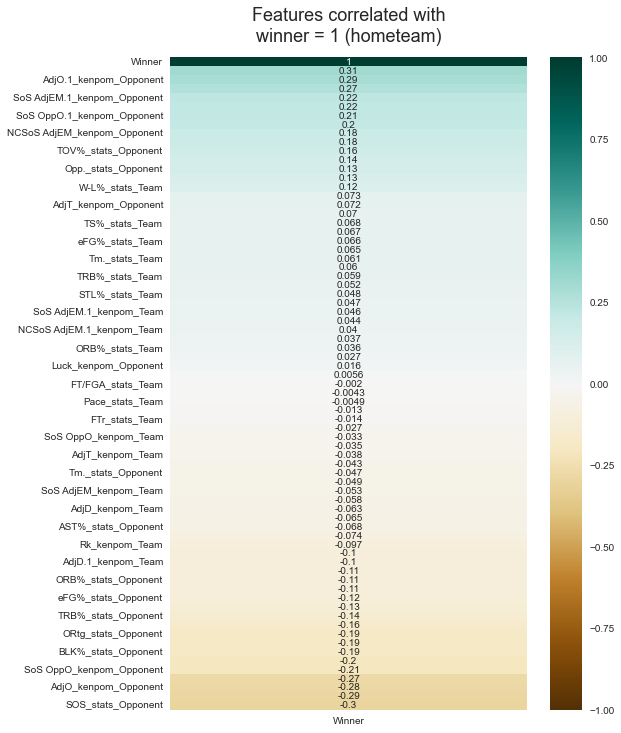

In [90]:
# correlations
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(model_data.corr()[['Winner']].sort_values(by='Winner', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features correlated with\nwinner = 1 (hometeam)', fontdict={'fontsize':18}, pad=16);

damn

In [95]:
# let's try a couple of models.  I'm starting with pycaret this time since my standard 4 don't usually tell me much

model_data_features = model_data.columns[model_data.columns != 'Winner']
model_data_target = model_data['Winner']

model_data_features

Index(['W-L%_stats_Team', 'SRS_stats_Team', 'SOS_stats_Team', 'Tm._stats_Team',
       'Opp._stats_Team', 'Pace_stats_Team', 'ORtg_stats_Team',
       'FTr_stats_Team', '3Par_stats_Team', 'TS%_stats_Team',
       'TRB%_stats_Team', 'AST%_stats_Team', 'STL%_stats_Team',
       'BLK%_stats_Team', 'eFG%_stats_Team', 'TOV%_stats_Team',
       'ORB%_stats_Team', 'FT/FGA_stats_Team', 'Rk_kenpom_Team',
       'AdjEM_kenpom_Team', 'AdjO_kenpom_Team', 'AdjO.1_kenpom_Team',
       'AdjD_kenpom_Team', 'AdjD.1_kenpom_Team', 'AdjT_kenpom_Team',
       'AdjT.1_kenpom_Team', 'Luck_kenpom_Team', 'Luck.1_kenpom_Team',
       'SoS AdjEM_kenpom_Team', 'SoS AdjEM.1_kenpom_Team',
       'SoS OppO_kenpom_Team', 'SoS OppO.1_kenpom_Team',
       'SoS OppD_kenpom_Team', 'SoS OppD.1_kenpom_Team',
       'NCSoS AdjEM_kenpom_Team', 'NCSoS AdjEM.1_kenpom_Team',
       'W-L%_stats_Opponent', 'SRS_stats_Opponent', 'SOS_stats_Opponent',
       'Tm._stats_Opponent', 'Opp._stats_Opponent', 'Pace_stats_Opponent',
      

In [96]:
model_data_target

0      1
1      1
2      1
3      1
4      0
      ..
216    1
217    0
218    1
219    0
220    1
Name: Winner, Length: 221, dtype: int64

In [97]:
# md_features is just a list of features.  I need the data with it

md_features = model_data.drop(['Winner'], axis=1)
md_features.head(5)

,W-L%_stats_Team,SRS_stats_Team,SOS_stats_Team,Tm._stats_Team,Opp._stats_Team,Pace_stats_Team,ORtg_stats_Team,FTr_stats_Team,3Par_stats_Team,TS%_stats_Team,...,Luck_kenpom_Opponent,Luck.1_kenpom_Opponent,SoS AdjEM_kenpom_Opponent,SoS AdjEM.1_kenpom_Opponent,SoS OppO_kenpom_Opponent,SoS OppO.1_kenpom_Opponent,SoS OppD_kenpom_Opponent,SoS OppD.1_kenpom_Opponent,NCSoS AdjEM_kenpom_Opponent,NCSoS AdjEM.1_kenpom_Opponent
0,0.778,0.770541,0.077922,0.721477,0.44757,0.662791,0.729858,0.988764,0.042254,0.686047,...,0.678571,0.161111,0.274600,0.718841,0.434783,0.522599,0.848837,0.867052,0.458027,0.337047
1,0.778,0.770541,0.077922,0.721477,0.44757,0.662791,0.729858,0.988764,0.042254,0.686047,...,0.526786,0.405556,0.001144,0.997101,0.060870,0.977401,0.906977,0.933526,0.267305,0.771588
2,0.778,0.770541,0.077922,0.721477,0.44757,0.662791,0.729858,0.988764,0.042254,0.686047,...,0.428571,0.575000,0.223684,0.805797,0.373913,0.666667,0.872093,0.895954,0.363034,0.554318
3,0.778,0.770541,0.077922,0.721477,0.44757,0.662791,0.729858,0.988764,0.042254,0.686047,...,0.434524,0.561111,0.581236,0.226087,0.486957,0.429379,0.302326,0.121387,0.863402,0.011142
4,0.778,0.770541,0.077922,0.721477,0.44757,0.662791,0.729858,0.988764,0.042254,0.686047,...,0.205357,0.916667,0.359840,0.544928,0.426087,0.550847,0.662791,0.554913,0.349779,0.593315


In [98]:
md_target = model_data_target

In [99]:
# split data

X_train, X_test, y_train, y_test = train_test_split(md_features, md_target, test_size=0.30)

In [101]:
# pycaret:

setup(data = model_data, target = 'Winner')

,Description,Value
0,Session id,3651
1,Target,Winner
2,Target type,Binary
3,Original data shape,"(221, 73)"
4,Transformed data shape,"(221, 73)"
5,Transformed train set shape,"(154, 73)"
6,Transformed test set shape,"(67, 73)"
7,Numeric features,72
8,Preprocess,True
9,Imputation type,simple


In [102]:
logistic_regression = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6250,0.5208,0.7500,0.7500,0.7500,0.0000,0.0000
1,0.7500,0.6458,0.9167,0.7857,0.8462,0.2000,0.2182
2,0.7500,0.6667,0.9167,0.7857,0.8462,0.2000,0.2182
3,0.7500,0.6875,1.0000,0.7500,0.8571,0.0000,0.0000
4,0.8000,0.7222,1.0000,0.8000,0.8889,0.0000,0.0000
5,0.7333,0.5556,0.9167,0.7857,0.8462,-0.1111,-0.1336
6,0.8000,0.6136,1.0000,0.7857,0.8800,0.3284,0.4432
7,0.7333,0.2955,1.0000,0.7333,0.8462,0.0000,0.0000
8,0.7333,0.4545,1.0000,0.7333,0.8462,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [103]:
naive_bayes = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5625,0.5417,0.5833,0.7778,0.6667,0.0667,0.0727
1,0.6250,0.6250,0.5833,0.8750,0.7000,0.2500,0.2887
2,0.6250,0.7083,0.5833,0.8750,0.7000,0.2500,0.2887
3,0.8750,0.8125,0.9167,0.9167,0.9167,0.6667,0.6667
4,0.5333,0.5833,0.5833,0.7778,0.6667,-0.0606,-0.0680
5,0.5333,0.5833,0.5000,0.8571,0.6316,0.1026,0.1336
6,0.6667,0.6818,0.6364,0.8750,0.7368,0.3119,0.3425
7,0.5333,0.3636,0.7273,0.6667,0.6957,-0.2963,-0.3015
8,0.5333,0.6818,0.4545,0.8333,0.5882,0.1463,0.1846


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Quick aside: THIS is what I was looking for.  Sports games are generall high 50s, low 60s at best in terms of accuracy.

I think I've corrected my problem compared to Hoops Run 1.

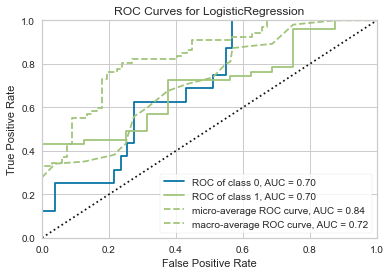

In [104]:
plot_model(logistic_regression, plot = 'auc')

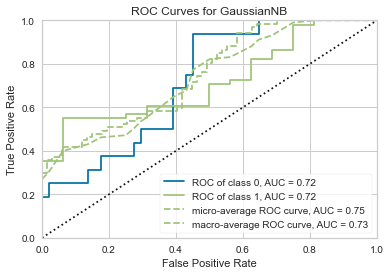

In [105]:
plot_model(naive_bayes, plot='auc')

In [106]:
# give me the best model:

best_model = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7542,0.6071,0.9500,0.7756,0.8523,0.1212,0.1396,0.0150
dummy,Dummy Classifier,0.7533,0.5000,1.0000,0.7533,0.8591,0.0000,0.0000,0.0150
rf,Random Forest Classifier,0.7404,0.6497,0.9159,0.7851,0.8407,0.1381,0.1501,0.0770
catboost,CatBoost Classifier,0.7279,0.6104,0.9235,0.7659,0.8346,0.0629,0.0734,3.2610
et,Extra Trees Classifier,0.7275,0.6499,0.9061,0.7759,0.8326,0.1000,0.0979,0.0650
gbc,Gradient Boosting Classifier,0.7271,0.5915,0.8818,0.7890,0.8279,0.1601,0.1844,0.0840
ridge,Ridge Classifier,0.7208,0.0000,0.9144,0.7627,0.8301,0.0474,0.0564,0.0100
knn,K Neighbors Classifier,0.7204,0.5122,0.9220,0.7583,0.8307,0.0353,0.0544,0.0300
xgboost,Extreme Gradient Boosting,0.7146,0.5838,0.8795,0.7763,0.8216,0.0954,0.0926,0.2010
lightgbm,Light Gradient Boosting Machine,0.6938,0.5813,0.8545,0.7711,0.8044,0.0712,0.0768,0.1800


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Wow.  Fascinating.  Logistic Regression does the best.  

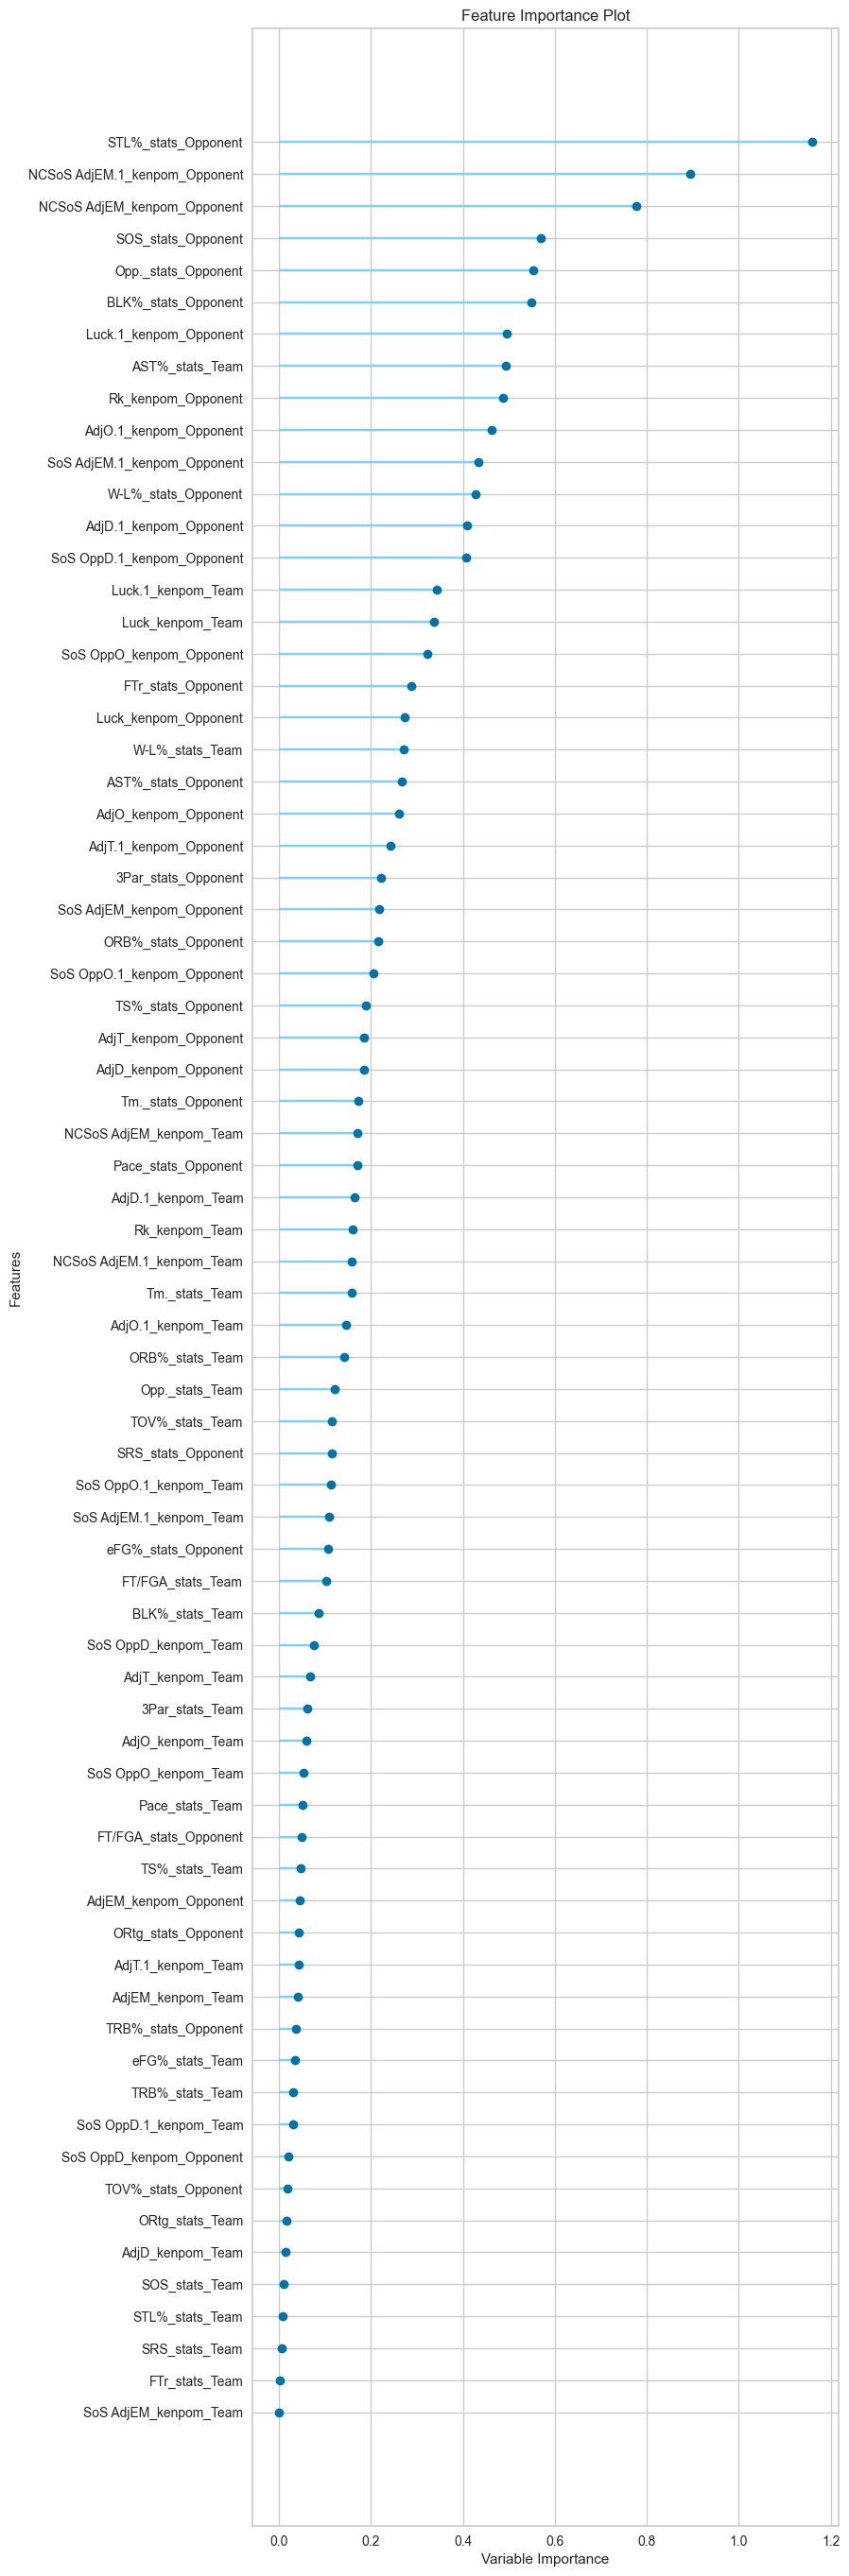

In [107]:
plot_model(logistic_regression, plot = 'feature_all')

This makes sense to me.  Non-conference schedules are dominating the data and these are generally teams with worse records than the big12 conference opponents.  There is still a flaw in the data though - my data is imbalanced.  The home team wins 3 times for every away team win.  That's going to be the prevailing "expert" analysis though for this league, so it would be interesting to level set everything and get down to 50/50 (or something closer to it).  

I also need to add WAY more data than just the big12 teams to this training data.  I will continue to look for a way to get team v team and home/away winners.  That will not only adjust my 3/1 winner ratio but will help boost my leading indicators too.

In [109]:
# now for my own logistic regression model so that I can see whether or not there is a 
# difference in how pycaret pre-processes data versus myself.  Hint: there is a difference.

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression Model
LR = LogisticRegression(solver="liblinear", random_state=1).fit(X_train, y_train)
LRpred = LR.predict(X_test)

# Naive Bayes Model
NB = GaussianNB().fit(X_train, y_train)
NBpred = NB.predict(X_test)

# Random Forest - define and fit
RFC = RandomForestClassifier(random_state=1).fit(X_train, y_train)
RFCpred = RFC.predict(X_test)

In [111]:
Precision_LR = cross_val_score(LR, md_features, md_target, cv=10, scoring='average_precision')
AUC_LR = cross_val_score(LR, md_features, md_target, cv=10, scoring='roc_auc')
print("Logistic Regression model (no rebalancing): Precision mean %0.2f (standard deviation: %0.2f)" % (Precision_LR.mean(), Precision_LR.std()))
print("Logistic Regression model (no rebalancing): AUC mean %0.2f (standard deviation: %0.2f)" % (AUC_LR.mean(), AUC_LR.std()))

# naive bayes
Precision_NB = cross_val_score(NB, md_features, md_target, cv=10, scoring='average_precision')
AUC_NB = cross_val_score(NB, md_features, md_target, cv=10, scoring='roc_auc')
print("Naive Bayes model (no rebalancing): Precision mean %0.2f (standard deviation: %0.2f)" % (Precision_NB.mean(), Precision_NB.std()))
print("Naive Bayes model (no rebalancing): AUC mean %0.2f (standard deviation: %0.2f)" % (AUC_NB.mean(), AUC_NB.std()))

# random forest
Precision_RFC = cross_val_score(RFC, md_features, md_target, cv=10, scoring='average_precision')
AUC_RFC = cross_val_score(RFC, md_features, md_target, cv=10, scoring='roc_auc')
print("Random Forest model (no rebalancing): Precision mean %0.2f (standard deviation: %0.2f)" % (Precision_RFC.mean(), Precision_RFC.std()))
print("Random Forest model (no rebalancing): AUC mean %0.2f (standard deviation: %0.2f)" % (AUC_RFC.mean(), AUC_RFC.std()))

Logistic Regression model (no rebalancing): Precision mean 0.89 (standard deviation: 0.06)
Logistic Regression model (no rebalancing): AUC mean 0.69 (standard deviation: 0.13)
Naive Bayes model (no rebalancing): Precision mean 0.90 (standard deviation: 0.03)
Naive Bayes model (no rebalancing): AUC mean 0.71 (standard deviation: 0.10)
Random Forest model (no rebalancing): Precision mean 0.86 (standard deviation: 0.09)
Random Forest model (no rebalancing): AUC mean 0.65 (standard deviation: 0.15)


This is great news.  These numbers are much more realistic, and they skew Big12 teams which is what I expected.  Precision is fairly high which is what I would hope for.

Perhaps there is a different scaler that would be more appropriate, and I think I could lose some of the non-important features in order to clean things up and to lower the noise in the data.

Next task is to find a way to bring the matchup data in for the rest of the teams and to do it in an automated way.  Then I could run this week to week and watch the most important indicators change.

For now, I'll take the combination of the sns.heatmap and the feature importance tables and apply that to games (no betting of course, just to see my beloved big12 teams eat each other alive before march madness.